## This notebook prototypes the final analysis in snec_chisq.py which is run on dark for speed

In [4]:
import math
import glob
import os
import sys

import numpy as np

from astropy.io import ascii as asc
import astropy.units as u
from astropy.table import Table
from matplotlib import pyplot as plt
import matplotlib as mpl


from utilities_az import visualization, supernova
%matplotlib

import matplotlib as mpl

Using matplotlib backend: Qt5Agg


In [5]:
plt.style.use(['seaborn-paper', 'az-paper-onecol'])

In [6]:
sys.path.append('/Users/bostroem/Desktop/research/not_my_code/SNEC-1.01/')
import chisq_analysis

In [7]:
DARK_DIR = '/Users/bostroem/dark'
FIG_DIR = '../figures/'
snec_models = '/Users/bostroem/dark/SNEC/snec_models'

In [8]:
def prepare_model_data(model_dir, type='mag'):
    if type=='mag':
        model_tbdata = asc.read(os.path.join(model_dir,'magnitudes.dat'),
                                names=['time', 'temp', 'weird_mag', 
                                       'u', 'g', 'r', 'i', 'z', 'U', 
                                       'B', 'V', 'R', 'I'])
    elif type=='lum':
        model_tbdata = asc.read(os.path.join(model_dir, 'lum_observed.dat'), names=['time', 'luminosity'])
    else:
        print('Type must be "lum" or "mag", {} not understood')
        sys.exit()
    #Observers call t_explosion the time when the explosion is first visible, therefore
    #the models should use this same conventions
    time_breakout = get_breakout_time(model_dir)
    if time_breakout is not None:
        model_tbdata['time'] = ((model_tbdata['time']-time_breakout)*u.second).to(u.day).value
    else:
        model_tbdata=None
    return model_tbdata

In [9]:
def get_breakout_time(model_dir):
    ofile = open(os.path.join(model_dir, 'info.dat'), 'r')
    all_lines = ofile.readlines()
    if len(all_lines)>6:
        time_breakout = float((all_lines[5].split('=')[1]).strip('seconds\n'))
    else: #SN never got to breakout
        time_breakout = None
    return time_breakout

# Get Luminosity

In [10]:
sn15oz = supernova.LightCurve2('asassn-15oz')
sn15oz.get_photometry()
sn15oz.get_abs_mag()

Calculating Absolute Magntidue with Extinction


In [11]:
sn15oz_tbdata = asc.read('../data/bolometric.txt', names=['phase', 'logL'])
sn15oz_tbdata['luminosity'] = 10**sn15oz_tbdata['logL']
sn15oz_phot_tbdata = sn15oz_tbdata[sn15oz_tbdata['phase']<150]

# Get Model Parameters

In [12]:
ni_mass =   np.array([0.083, 0.0965, 0.11])
energies =  np.array([0.5, 0.8, 1.1, 1.4, 1.7, 2.0])
masses =    np.array([11, 13, 15, 16, 17, 18, 21])
ni_mixing = np.array([5.0])
time_offsets = np.arange(-4, 4, 1)
Kvalues =   np.array([10, 20, 30, 35, 40, 50, 60])
radii =     np.array([1500, 1800, 2100, 2400, 2700, 3000, 3300])

snec_models = os.path.join(DARK_DIR,'SNEC/snec_models/')
snname = 'asassn15oz'
S2_start = 50
S2_end = 88  #Vary this parameter
snec_15oz = chisq_analysis.SnecAnalysis(snname, snec_models, S2_start, S2_end, 
                 ni_mass, ni_mixing, masses, energies, time_offsets, 
                 Kvalues, radii, fig_dir='../figures')

# Find best fit luminosity

#### This code has been moved into snec_chisq.py and run on dark

In [13]:
chisq_bolo = np.zeros((len(ni_mass), len(energies), len(masses), len(time_offsets), len(Kvalues), len(radii)))

# Best Model

In [70]:
min_indx_base_mod = np.where(chisq_bolo == np.nanmin(chisq_bolo))
best_ni_mass_indx = min_indx_base_mod[0][0]
best_energy_indx = min_indx_base_mod[1][0]
best_mass_indx = min_indx_base_mod[2][0]
best_time_indx = min_indx_base_mod[3][0]
best_k_indx = min_indx_base_mod[4][0]
best_r_indx = min_indx_base_mod[5][0]

best_ni_mass = ni_mass[best_ni_mass_indx]
best_ni_mix = 5.0
best_energy = energies[best_energy_indx]
best_mass = masses[best_mass_indx]
best_time_offset = time_offsets[best_time_indx]
best_Kvalue = Kvalues[best_k_indx]
best_radius = radii[best_r_indx]

print('best model parameters:\n mass: {}\n energy: {} \n K: {} \n R: {} \n t_offset: {} \n Ni mass: {}'.format(best_mass, best_energy, best_Kvalue, best_radius, best_time_offset, best_ni_mass))

best model parameters:
 mass: 17
 energy: 1.1 
 K: 40 
 R: 1800 
 t_offset: -4 
 Ni mass: 0.083


$M_{CSM} = 4\pi \int^{R_{ext}}_{R_{phot}}{\frac{K}{r^{2}}(r^{2}dr)} = 4\pi K \left(R_{ext} - R_{phot}\right)$

In [120]:
R_phot = 967*u.Rsun
M_csm_opti = 4*math.pi*(best_Kvalue*10**17*u.g/u.cm)*((best_radius*u.Rsun).to(u.cm) - R_phot.to(u.cm))
print(M_csm_opti.to(u.Msun))
print('M_CSM = {:2.2}'.format(M_csm_opti.to(u.Msun)))
M_csm_opti = 4*math.pi*(10*10**17*u.g/u.cm)*((2400*u.Rsun).to(u.cm) - R_phot.to(u.cm))
print(M_csm_opti.to(u.Msun))
print('M_CSM = {:2.2}'.format(M_csm_opti.to(u.Msun)))

1.4649291947299974 solMass
M_CSM = 1.5 solMass
0.6300250708427629 solMass
M_CSM = 0.63 solMass


# Make plots

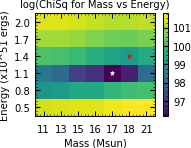

In [117]:
fig = plt.figure()
fig.subplotpars.update(top=0.9)
ax = fig.add_subplot(1,1,1)
ax.set_title('log(ChiSq for Mass vs Energy)')
im = ax.imshow(np.log(chisq[best_ni_mass_indx,:, :, best_time_indx, best_k_indx, best_r_indx ]), interpolation='nearest')
ax.set_xlabel('Mass (Msun)')
ax.set_ylabel('Energy (x10^51 ergs)')
ax.set_xticks(np.arange(len(masses)))
ax.set_xticklabels(list(masses))
ax.set_yticks(np.arange(len(energies)))
ax.set_yticklabels(list(energies))
ax.plot(5, 3, 'r*')
ax.plot(4, 2, 'w*')
fig.colorbar(im)
plt.savefig(os.path.join(FIG_DIR, 'chisq_Lbolo_MvsE.pdf'))

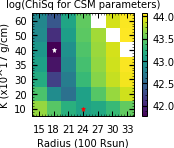

In [119]:
fig = plt.figure()
fig.subplotpars.update(top=0.9)
ax = fig.add_subplot(1,1,1)
ax.set_title('log(ChiSq for CSM parameters)')
im = ax.imshow(np.log10(chisq[best_ni_mass_indx,best_energy_indx, best_mass_indx, best_time_indx, :, : ]), interpolation='nearest')
ax.set_xlabel('Radius (100 Rsun)')
ax.set_ylabel('K (x10^17 g/cm)')
ax.set_xticks(np.arange(0,7))
ax.set_xticklabels(np.int_(radii/100))
ax.set_yticks(np.arange(0, 7))
ax.set_yticklabels(Kvalues)
ax.plot(3, 0, 'r*')
ax.plot(1, 4, 'w*')
fig.colorbar(im)
plt.savefig(os.path.join(FIG_DIR, 'chisq_Lbolo_KvsR.pdf'))

# Compare Bolometric and Color Models

In [20]:
best_model_dir_bolo = os.path.join(snec_models, 
                                         'Ni_mass_{:1.4f}'.format(0.083),
                                         'Ni_mixing_{:1.1f}'.format(5.0),
                                         'M{:2.1f}'.format(17),
                                         'E_{:1.3f}'.format(1.4),
                                         'K_{:2.1f}'.format(10), 
                                         'R_{}'.format(2400),
                                         'Data')

In [21]:
best_model_csm_dir = os.path.join(snec_models, 
                                 'Ni_mass_{:1.4f}'.format(0.083),
                                 'Ni_mixing_{:1.1f}'.format(5.0),
                                 'M{:2.1f}'.format(18.0),
                                 'E_{:1.3f}'.format(1.400),
                                 'K_{:2.1f}'.format(10.0), 
                                 'R_{}'.format(2400),
                                 'Data')

In [22]:
best_model_bare_dir = os.path.join(snec_models, 
                                 'Ni_mass_{:1.4f}'.format(0.083),
                                 'Ni_mixing_{:1.1f}'.format(5.0),
                                 'M{:2.1f}'.format(18.0),
                                 'E_{:1.3f}'.format(1.400),
                                 'K_{:2.1f}'.format(0), 
                                 'R_{}'.format(0),
                                 'Data')

In [23]:
snec_color_tbdata = asc.read(os.path.join(best_model_csm_dir, 'lum_observed.dat'), names=['phase', 'luminosity'])
snec_bare_bolo_tbdata = asc.read(os.path.join(best_model_bare_dir, 'lum_observed.dat'), names=['phase', 'luminosity'])
snec_bolo_tbdata = asc.read(os.path.join(best_model_dir_bolo, 'lum_observed.dat'), names=['phase', 'luminosity'])

In [24]:
breakout_time_color_csm = get_breakout_time(best_model_csm_dir)
snec_phase = ((snec_bolo_tbdata['phase']-breakout_time_color_csm)*u.s).to(u.day)
breakout_time_color_bare = get_breakout_time(best_model_bare_dir)
snec_bare_phase = ((snec_bare_bolo_tbdata['phase']-breakout_time_color_bare)*u.s).to(u.day)
breakout_time_bolo = get_breakout_time(best_model_dir_bolo)
snec_bolo_phase = ((snec_bolo_tbdata['phase']-breakout_time_bolo)*u.s).to(u.day)

In [27]:
fig = plt.figure()
fig.subplotpars.update(0.25)
ax = fig.add_subplot(1,1,1)
ax.plot(snec_phase, np.log10(snec_color_tbdata['luminosity']), label='Best Color Model with CSM')
ax.plot(snec_bare_phase, np.log10(snec_bare_bolo_tbdata['luminosity']), label='Best Color Model without CSM', ls='--')
ax.plot(snec_bolo_phase, np.log10(snec_bolo_tbdata['luminosity']), label='Best Bolometric Model with CSM', ls=':')
ax.plot(sn15oz_tbdata['phase'], sn15oz_tbdata['logL'], '.', label='Corrected Bolometric Luminosity')
ax.set_xlim(0, 100)
ax.set_ylim(42, 44)
ax.legend()
ax.set_xlabel('Phase (days)')
ax.set_ylabel('log(L) (erg/s)')
plt.savefig(os.path.join(FIG_DIR, 'color_bolo_snec_model_comp.pdf'))

/Users/bostroem/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log10
/Users/bostroem/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log10
/Users/bostroem/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10
/Users/bostroem/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log10
/Users/bostroem/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10


In [26]:
best_csm_color_tbdata = prepare_model_data(best_model_csm_dir)
best_bare_color_tbdata = prepare_model_data(best_model_bare_dir)
best_csm_bolo_tbdata = prepare_model_data(best_model_dir_bolo)

/Users/bostroem/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10
/Users/bostroem/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in log10
/Users/bostroem/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: divide by zero encountered in log10
/Users/bostroem/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in log10


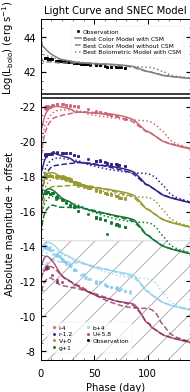

In [159]:
fig = plt.figure()
fig.set_figheight(5.5)
fig.subplotpars.update(bottom=.09, left=0.22)

ax = fig.add_subplot(1,1,1)
#ax = fig.add_axes([0.25, 0.3, 0.7, 0.65])
#ax_bolo = fig.add_axes([0.25, 0.1, 0.7, 0.2])

toffset = -4
ax.axhspan(-4, -14.3, hatch='/', facecolor='none', edgecolor='k')
ax.axhspan(-4, -14.3, color='white', alpha = 0.7)


ax.set_title('Light Curve and SNEC Model')


ax_bolo = ax.twinx()
lbolo, = ax_bolo.plot(sn15oz_tbdata['phase']+toffset, sn15oz_tbdata['logL'], '.',  label='Observation')
ax_bolo.plot(snec_phase, np.log10(snec_color_tbdata['luminosity']), label='Best Color Model with CSM', color='gray', ls='-')
ax_bolo.plot(snec_bare_phase, np.log10(snec_bare_bolo_tbdata['luminosity']), label='Best Color Model without CSM', color='gray', ls='--')
ax_bolo.plot(snec_bolo_phase, np.log10(snec_bolo_tbdata['luminosity']), label='Best Bolometric Model with CSM', color='gray', ls=':')
ax_bolo.legend()

ax.plot([], [])
li, = ax.plot(sn15oz.phase['i']+toffset, sn15oz.abs_mag['i']-4, '.', label='i-4')
ax.plot(best_csm_color_tbdata['time'], best_csm_color_tbdata['i']-4,color=li.get_color())
ax.plot(best_bare_color_tbdata['time'], best_bare_color_tbdata['i']-4, ls='--', color=li.get_color())
ax.plot(best_csm_bolo_tbdata['time'], best_csm_bolo_tbdata['i']-4, ls=':', color=li.get_color())

lr, = ax.plot(sn15oz.phase['r']+toffset, sn15oz.abs_mag['r']-1.2, '.', label='r-1.2')
ax.plot(best_csm_color_tbdata['time'], best_csm_color_tbdata['r']-1.2, color=lr.get_color())
ax.plot(best_bare_color_tbdata['time'], best_bare_color_tbdata['r']-1.2, ls='--', color=lr.get_color())
ax.plot(best_csm_bolo_tbdata['time'], best_csm_bolo_tbdata['r']-1.2, ls=':', color=lr.get_color())

lv, = ax.plot(sn15oz.phase['V']+toffset, sn15oz.abs_mag['V'], '.', label='V+0')
ax.plot(best_csm_color_tbdata['time'], best_csm_color_tbdata['V'],color=lv.get_color() )
ax.plot(best_bare_color_tbdata['time'], best_bare_color_tbdata['V'], ls='--', color=lv.get_color())
ax.plot(best_csm_bolo_tbdata['time'], best_csm_bolo_tbdata['V'], ls=':', color=lv.get_color())

lg, = ax.plot(sn15oz.phase['g']+toffset, sn15oz.abs_mag['g']+1, '.', label='g+1')
ax.plot(best_csm_color_tbdata['time'], best_csm_color_tbdata['g']+1, color=lg.get_color())
ax.plot(best_bare_color_tbdata['time'], best_bare_color_tbdata['g']+1, ls='--', color=lg.get_color())
ax.plot(best_csm_bolo_tbdata['time'], best_csm_bolo_tbdata['g']+1, ls=':', color=lg.get_color())

lb, = ax.plot(sn15oz.phase['B']+toffset, sn15oz.abs_mag['B']+4, '.', alpha=0.75, label='b+4')
ax.plot(best_csm_color_tbdata['time'], best_csm_color_tbdata['B']+4, color=lb.get_color(), alpha=0.75)
ax.plot(best_bare_color_tbdata['time'], best_bare_color_tbdata['B']+4, ls='--', color=lb.get_color(), alpha=0.75)
ax.plot(best_csm_bolo_tbdata['time'], best_csm_bolo_tbdata['B']+4, ls=':', color=lb.get_color(), alpha=0.75)

lu, = ax.plot(sn15oz.phase['U']+toffset, sn15oz.abs_mag['U']+5.8, '.', alpha=0.75, label='U+5.8')
ax.plot(best_csm_color_tbdata['time'], best_csm_color_tbdata['U']+5.8, color=lu.get_color(),  alpha=0.75)
ax.plot(best_bare_color_tbdata['time'], best_bare_color_tbdata['U']+5.8, ls='--', color=lu.get_color(), alpha=0.75)
ax.plot(best_csm_bolo_tbdata['time'], best_csm_bolo_tbdata['U']+5.8, ls='--', color=lu.get_color(), alpha=0.75)

#ax.barh(-9.80, 85, 1.,5.5, facecolor='w', edgecolor='LightGrey', alpha=0.75) #y, width, height, left
#ax.annotate(s='Without CSM (wind)', xy=(12, -10), xytext=(32, -9.9), xycoords='data', 
#            arrowprops={'arrowstyle':'-',  'linestyle':'--','linewidth':1.5}, fontsize=6.0, 
#            backgroundcolor='none')
#ax.annotate(s='With CSM (wind)', xy=(12, -9.5), xytext=(32, -9.4), xycoords='data', fontsize=6.0, 
#            arrowprops={'arrowstyle':'-', 'linewidth':1.5}, 
#            backgroundcolor='none')



ax.set_ylim(-7.5, -27)
ax.set_yticks(     [-26, -24, -22, -20, -18, -16, -14, -12, -10, -8])
ax.set_yticklabels([44, 42, -22, -20, -18, -16, -14, -12, -10, -8])
ax.set_xlim(0, 140)
ax.set_ylabel('Absolute magnitude + offset', position=(1, 0.4))
#plt.grid()
handles, labels = ax.get_legend_handles_labels()

ax_bolo.set_ylim(25.5, 45)
ax_bolo.set_yticks(np.arange(28, 45, 2))
#ax_bolo.set_yticks(np.arange(44,2))

patch = mpl.patches.Rectangle((0, -22.7), 140, 0.25, color='w', fill=True)
ax.add_patch(patch)
patch_bolo = mpl.patches.Rectangle((0, 40.45), 140, 0.25, color='w', fill=True)
ax_bolo.add_patch(patch_bolo)
ax_bolo.axhline(40.75)
ax_bolo.axhline(40.5)
#ax_bolo.grid()

ax_bolo.set_yticklabels([])
leg = ax.legend(handles[::4]+[lbolo], labels[::4]+[lbolo.get_label()], ncol=2, loc='lower left')#, bbox_to_anchor=[0.3, -.02, 0.75, 0.2])
#ax_bolo.legend([lbolo], [lbolo.get_label()], loc='upper left')
ax_bolo.set_ylabel(r'$\rm Log(L_{bolo})$ (erg $\rm s^{-1})$', position=(1, 0.92))
ax_bolo.yaxis.set_label_position('left')
ax_bolo.yaxis.labelpad=25.0
ax.set_xlabel('Phase (day)')
plt.savefig(os.path.join(FIG_DIR, 'snec_lc_comp.pdf'))

# Get best color chisq

In [33]:
filters_1 = ['U', 'B', 'V', 'R', 'I']
filters_2 = ['V', 'R', 'I']
end_uv = 30
end_plateau = 150

In [34]:
sn15oz = supernova.LightCurve2('asassn-15oz')
sn15oz.get_photometry()
sn15oz.get_abs_mag()

first_indx = {}
second_indx = {}
for ifilter in filters_1:
    first_indx[ifilter] = sn15oz.phase[ifilter]<end_uv
    if (first_indx[ifilter]==False).all():
        print('Warning: no data in first phase for filter {}'.format(ifilter))
for ifilter in filters_2:
    second_indx[ifilter] = (sn15oz.phase[ifilter]>=end_uv) & (sn15oz.phase[ifilter]<=end_plateau)
    if (second_indx[ifilter]==False).all():
        print('Warning: no data in second phase for filter {}'.format(ifilter))    
first_obs_array =  np.hstack([sn15oz.abs_mag[ifilter][first_indx[ifilter]] for ifilter in filters_1])
second_obs_array = np.hstack([sn15oz.abs_mag[ifilter][second_indx[ifilter]] for ifilter in filters_2])

Calculating Absolute Magntidue with Extinction


In [35]:
norm1=None
norm2=None
norm=None
norm = len(first_obs_array.flatten())+len(second_obs_array.flatten())
if norm1:
    del norm1
    del norm2
#norm1 = len(filters_1)
#norm2 = len(filters2)
#if norm:
    #del norm

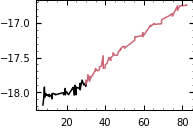

In [36]:
plt.figure()
plt.plot(sn15oz.phase['V'][first_indx['V']], sn15oz.abs_mag['V'][first_indx['V']])
plt.plot(sn15oz.phase['V'][second_indx['V']], sn15oz.abs_mag['V'][second_indx['V']])

In [37]:
chisq_color = np.zeros((len(ni_mass), len(energies), len(masses), len(time_offsets), len(Kvalues), len(radii)))

In [ ]:
%%time
with open('missing_snec_models_color.txt', 'a') as missing_ofile:
    with open('chisq_color.csv', 'w') as chisq_ofile:
        try:
            tbdata = asc.read('chisq_color.csv', names=['ni_mass', 'energy', 'mass', 'time_offset', 'K', 'R', 'chisq'])
            last_done = tbdata[-1]
        except:
            last_done = Table([[0.], [0.], [0.], [0.], [0.], [0.], [0.]], names=['ni_mass', 'energy', 'mass', 'time_offset', 'K', 'R', 'chisq'])
        for i, ini_mass in enumerate(ni_mass):
            if last_done['ni_mass'] > ini_mass:
                continue
            for j, jenergy in enumerate(energies):
                if last_done['energy'] > jenergy:
                    continue
                for m, mmass in enumerate(masses):
                    if last_done['mass']>mmass:
                        continue
                    for k, kval in enumerate(Kvalues):
                        if last_done['K'] > kval:
                            continue
                        for r, rradius in enumerate(radii):
                            if last_done['R']> rradius:
                                continue
                            model_dir = os.path.join(snec_models, 
                                         'Ni_mass_{:1.4f}'.format(ini_mass),
                                         'Ni_mixing_{:1.1f}'.format(5.0),
                                         'M{:2.1f}'.format(mmass),
                                         'E_{:1.3f}'.format(jenergy),
                                         'K_{:2.1f}'.format(kval), 
                                         'R_{}'.format(rradius),
                                         'Data')
                            if os.path.exists(os.path.join(model_dir, 'magnitudes.dat')):
                                model_tbdata = prepare_model_data(model_dir)
                                if model_tbdata is None:
                                    missing_ofile.write('breakout time is None for {}\n'.format(model_dir))
                                    chisq_color[i,j,m,:,k,r] = np.nan
                                else:
                                    first_lc = np.hstack([np.interp(sn15oz.phase[ifilter][first_indx[ifilter]], model_tbdata['time'], model_tbdata[ifilter]) for ifilter in filters_1])
                                    second_lc = np.hstack([np.interp(sn15oz.phase[ifilter][second_indx[ifilter]], model_tbdata['time'], model_tbdata[ifilter]) for ifilter in filters_2])
                                    for t, toff in enumerate(time_offsets):
                                        first_chisq = np.sum((first_obs_array - first_lc)**2/first_lc)
                                        second_chisq = np.sum((second_obs_array - second_lc)**2/second_lc)
                                        if norm1:
                                            
                                            ichi = first_chisq/norm1 + second_chisq/norm2
                                        elif norm:
                                            ichi = (first_chisq + second_chisq)/norm
                                        else:
                                            print('neither norm nor norm1 were defined')
                                            break
                                        chisq_color[i, j, m, t, k, r] = ichi
                                        chisq_ofile.write('{},{},{},{},{},{},{}'.format(ini_mass, jenergy, mmass, kval, rradius, toff, chisq_color[i, j, m, t, k, r]))
                            else:
                                missing_ofile.write('No file found for {}\n'.format(model_dir))
                                chisq_color[i,j,m,:,k,r] = np.nan
                                for toff in time_offsets:
                                        chisq_ofile.write('{},{},{},{},{},{},{}'.format(ini_mass, jenergy, mmass, kval, rradius, toff, np.nan))

In [20]:
min_indx_base_mod = np.where(chisq_color == np.nanmin(chisq_color))
best_ni_mass_indx = min_indx_base_mod[0][0]
best_energy_indx = min_indx_base_mod[1][0]
best_mass_indx = min_indx_base_mod[2][0]
best_time_indx = min_indx_base_mod[3][0]
best_k_indx = min_indx_base_mod[4][0]
best_r_indx = min_indx_base_mod[5][0]

best_ni_mass = ni_mass[best_ni_mass_indx]
best_ni_mix = 5.0
best_energy = energies[best_energy_indx]
best_mass = masses[best_mass_indx]
best_time_offset = time_offsets[best_time_indx]
best_Kvalue = Kvalues[best_k_indx]
best_radius = radii[best_r_indx]

print('best model parameters:\n mass: {}\n energy: {} \n K: {} \n R: {} \n t_offset: {} \n Ni mass: {}'.format(best_mass, best_energy, best_Kvalue, best_radius, best_time_offset, best_ni_mass))

best model parameters:
 mass: 11
 energy: 0.5 
 K: 10 
 R: 1500 
 t_offset: -4 
 Ni mass: 0.083


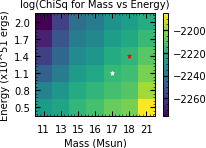

In [33]:
fig = plt.figure()
fig.subplotpars.update(top=0.9)
ax = fig.add_subplot(1,1,1)
ax.set_title('log(ChiSq for Mass vs Energy)')
im = ax.imshow(chisq_color[best_ni_mass_indx,:, :, best_time_indx, best_k_indx, best_r_indx ], interpolation='nearest')
ax.set_xlabel('Mass (Msun)')
ax.set_ylabel('Energy (x10^51 ergs)')
ax.set_xticks(np.arange(len(masses)))
ax.set_xticklabels(list(masses))
ax.set_yticks(np.arange(len(energies)))
ax.set_yticklabels(list(energies))
ax.plot(5, 3, 'r*')
ax.plot(4, 2, 'w*')
fig.colorbar(im)

# Compare models

In [18]:
sn15oz = supernova.LightCurve2('asassn-15oz')
sn15oz.get_photometry()
sn15oz.get_abs_mag()
sn15oz_lum = asc.read('../data/bolometric.txt', names=['phase', 'logL'])
sn15oz_lum['luminosity'] = 10**sn15oz_lum['logL']

Calculating Absolute Magntidue with Extinction


In [9]:
#Old best chi-sq color
model_dir1 = os.path.join(snec_models, 
             'Ni_mass_{:1.4f}'.format(0.083),
             'Ni_mixing_{:1.1f}'.format(5.0),
             'M{:2.1f}'.format(18),
             'E_{:1.3f}'.format(1.4),
             'K_{:2.1f}'.format(10), 
             'R_{}'.format(2400),
             'Data')
toffset1=4
tbdata1 = prepare_model_data(model_dir1)

In [10]:
#new best chi-sq color
model_dir2 = os.path.join(snec_models, 
             'Ni_mass_{:1.4f}'.format(0.083),
             'Ni_mixing_{:1.1f}'.format(5.0),
             'M{:2.1f}'.format(17),
             'E_{:1.3f}'.format(1.4),
             'K_{:2.1f}'.format(40), 
             'R_{}'.format(1800),
             'Data')
#Phase +3 --> texpl = texpl-3
toffset2=3
tbdata2 = prepare_model_data(model_dir2)

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
l1, = ax.plot(sn15oz.phase['r']+toffset1, sn15oz.abs_mag['r'], 'o', label='old_data, r')
l2, = ax.plot(sn15oz.phase['r']+toffset2, sn15oz.abs_mag['r'], 's', label='new data r')
ax.plot(tbdata1['time'], tbdata1['r'], color=l1.get_color(), label='old fit r')
ax.plot(tbdata2['time'], tbdata2['r'], color=l2.get_color(), label='new fit r')
l1, = ax.plot(sn15oz.phase['i']+toffset1, sn15oz.abs_mag['i']+1, 'o', label='old data i+1')
l2, = ax.plot(sn15oz.phase['i']+toffset2, sn15oz.abs_mag['i']+1, 's', label='new data i+1')
ax.plot(tbdata1['time'], tbdata1['i']+1, color=l1.get_color(), label='old fit i+1')
ax.plot(tbdata2['time'], tbdata2['i']+1, color=l2.get_color(), label = 'new fit i+1')
l1, = ax.plot(sn15oz.phase['g']+toffset1, sn15oz.abs_mag['g']+2, 'o', label = 'old data g+2')
l2, = ax.plot(sn15oz.phase['g']+toffset2, sn15oz.abs_mag['g']+2, 's', label='new data g+2')
ax.plot(tbdata1['time'], tbdata1['g']+2, color=l1.get_color(), label='old fit g+2')
ax.plot(tbdata2['time'], tbdata2['g']+2, color=l2.get_color(), label='new fit g+2')
ax.invert_yaxis()
ax.set_ylim(ymin=-13)
ax.set_xlim(xmax=150)
ax.legend()

In [25]:
#Old luminosity
model_dir3 = os.path.join(snec_models, 
             'Ni_mass_{:1.4f}'.format(0.083),
             'Ni_mixing_{:1.1f}'.format(5.0),
             'M{:2.1f}'.format(17),
             'E_{:1.3f}'.format(1.1),
             'K_{:2.1f}'.format(40), 
             'R_{}'.format(1800),
             'Data')
toffset3=4
tbdata3 = prepare_model_data(model_dir3, type='lum')

In [26]:
#New luminosity
model_dir4 = os.path.join(snec_models, 
             'Ni_mass_{:1.4f}'.format(0.11),
             'Ni_mixing_{:1.1f}'.format(5.0),
             'M{:2.1f}'.format(16),
             'E_{:1.3f}'.format(1.1),
             'K_{:2.1f}'.format(40), 
             'R_{}'.format(3000),
             'Data')
toffset4=-2
tbdata4 = prepare_model_data(model_dir4, type='lum')

In [31]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
l1, = ax.plot(sn15oz_lum['phase']+toffset3, sn15oz_lum['luminosity'], 'o', label='old_data, Lum')
l2, = ax.plot(sn15oz_lum['phase']+toffset4, sn15oz_lum['luminosity'], 's', label='new data Lum')
ax.plot(tbdata3['time'], tbdata3['luminosity'], color=l1.get_color(), label='old fit Lum')
ax.plot(tbdata4['time'], tbdata4['luminosity'], color=l2.get_color(), label='new fit Lum')
ax.set_ylim(0E42, 7E42)
ax.set_xlim(xmax=150)

(-27.20264568373792, 150)

# Plot all filters

In [50]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(sn15oz.phase['g'], sn15oz.abs_mag['g'], 'o', label='g')
ax.plot(sn15oz.phase['V'], sn15oz.abs_mag['V'], 's', label='V')

ax.plot(sn15oz.phase['i'], sn15oz.abs_mag['i']+2, 'o', label='i')
ax.plot(sn15oz.phase['I'], sn15oz.abs_mag['I']+2, 's', label='I')

ax.plot(sn15oz.phase['r'], sn15oz.abs_mag['r']-1, 'o', label='r')
ax.plot(sn15oz.phase['R'], sn15oz.abs_mag['R']-1, 's', label='R')

ax.invert_yaxis()
ax.legend()
ax.set_xlim(xmax=90)
ax.set_ylim(-15, -21)

(-15, -21)

#### Don't use R and I because there isn't complete data

# Compare Best Bolometric Fit and Best color Fit

### Color

In [30]:
#Observations
sn15oz = supernova.LightCurve2('asassn-15oz')
sn15oz.get_photometry()
sn15oz.get_abs_mag()

photospheric_indx = {}
end_plateau=90

for ifilter in ['U', 'B', 'g', 'r', 'i']:
    photospheric_indx[ifilter]=sn15oz.phase[ifilter]<90

Calculating Absolute Magntidue with Extinction


In [56]:
#Model
toffset_color= 3
best_color_dir = os.path.join(snec_models, 
             'Ni_mass_{:1.4f}'.format(0.083),
             'Ni_mixing_{:1.1f}'.format(5.0),
             'M{:2.1f}'.format(17),
             'E_{:1.3f}'.format(1.4),
             'K_{:2.1f}'.format(40), 
             'R_{}'.format(1800),
             'Data')

best_color_model_mag = prepare_model_data(best_color_dir)
best_color_model_lum = prepare_model_data(best_color_dir, type='lum')
model_photo_indx_mag = (best_color_model_mag['time']<end_plateau) & (best_color_model_mag['time'] > 2)
model_photo_indx_lum = (best_color_model_lum['time']<end_plateau) & (best_color_model_lum['time'] > 2)

### Bolometric Luminosity

In [82]:
#sn15oz_bolo = Table.read('../Data/bolometric.txt', names=['time', 'logL'], format='ascii')
sn15oz_bolo=Table.read('../Data/asassn-15oz_bolo_BB.txt', names=['time', 'logL'], format='ascii')
obs_bolo_photo_indx = sn15oz_bolo['time']< end_plateau

In [85]:
#Model
toffset_bolo= 2
best_bolo_dir = os.path.join(snec_models, 
             'Ni_mass_{:1.4f}'.format(0.083),
             'Ni_mixing_{:1.1f}'.format(5.0),
             'M{:2.1f}'.format(21),
             'E_{:1.3f}'.format(0.8),
             'K_{:2.1f}'.format(30), 
             'R_{}'.format(2400),
             'Data')

best_bolo_model_mag = prepare_model_data(best_bolo_dir)
best_bolo_model_lum = prepare_model_data(best_bolo_dir, type='lum')
model_photo_indx_mag_bolo = (best_bolo_model_mag['time']<end_plateau) & (best_bolo_model_mag['time'] > 2)
model_photo_indx_lum_bolo = (best_bolo_model_lum['time']<end_plateau) & (best_bolo_model_lum['time'] > 2)

In [86]:
fig = plt.figure()
fig.set_figheight(5)
fig.subplotpars.update(hspace=0, left=0.22, bottom=0.1)
ax_bolo = fig.add_subplot(6,1,1)
ax_U = fig.add_subplot(6,1,2, sharex=ax_bolo)
ax_B = fig.add_subplot(6,1,3, sharex=ax_bolo)
ax_g = fig.add_subplot(6,1,4, sharex=ax_bolo)
ax_r = fig.add_subplot(6,1,5, sharex=ax_bolo)
ax_i = fig.add_subplot(6,1,6, sharex=ax_bolo)

ax_color_list = [ax_U, ax_B, ax_g, ax_r, ax_i]

ax_bolo.plot(sn15oz_bolo['time'][obs_bolo_photo_indx]+toffset_bolo, sn15oz_bolo['logL'][obs_bolo_photo_indx], 'o', label='Observations')
ax_bolo.plot(best_color_model_lum['time'][model_photo_indx_lum], np.log10(best_color_model_lum['luminosity'][model_photo_indx_lum]), label='Color model')
ax_bolo.plot(best_bolo_model_lum['time'][model_photo_indx_lum_bolo], 
             np.log10(best_bolo_model_lum['luminosity'][model_photo_indx_lum_bolo]), label='Bolometric model')

ax_bolo.set_ylabel(r'log(L$_{bolo}$)')
ax_bolo.legend()

for ifilter, iax in zip(['U', 'B', 'g', 'r', 'i'], ax_color_list):
    iax.plot(sn15oz.phase[ifilter][photospheric_indx[ifilter]]+toffset_color, sn15oz.abs_mag[ifilter][photospheric_indx[ifilter]], 'o')
    iax.plot(best_color_model_mag['time'][model_photo_indx_mag], best_color_model_mag[ifilter][model_photo_indx_mag], label='Color model')
    iax.plot(best_bolo_model_mag['time'][model_photo_indx_mag_bolo], 
                 best_bolo_model_mag[ifilter][model_photo_indx_mag_bolo], label='Bolometric model')
    iax.set_ylabel('{}'.format(ifilter))
    iax.invert_yaxis()
iax.set_xlabel('Phase (days)')
plt.savefig(os.path.join(FIG_DIR, 'chisq_comp_bolo_color.pdf'))